# Tutorial 9: Inference
## Overview
In this tutorial we are going to cover:
* [Running inference with the transform method](#t09inference)
    * [Pipeline.transform](#t09pipeline)
    * [Network.transform](#t09network)
* [Related Apphub Examples](#t09apphub)

<a id='t09inference'></a>

## Running inference with transform method

Running inference means using a trained deep learning model to get a prediction from some input data. Users can use `pipeline.transform` and `network.transform` to feed the data forward and get the computed result in any operation mode. Here we are going to use an end-to-end example (the same example code from [tutorial 8](t08_mode.ipynb)) on MNIST image classification to demonstrate how to run inference.  

We first train a deep leaning model with the following code:

In [1]:
import fastestimator as fe
from fastestimator.dataset.data import mnist
from fastestimator.schedule import cosine_decay
from fastestimator.trace.adapt import LRScheduler
from fastestimator.trace.io import BestModelSaver
from fastestimator.trace.metric import Accuracy
from fastestimator.op.numpyop.univariate import ExpandDims, Minmax, CoarseDropout
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.architecture.tensorflow import LeNet


train_data, eval_data = mnist.load_data()
test_data = eval_data.split(0.5)
model = fe.build(model_fn=LeNet, optimizer_fn="adam")

pipeline = fe.Pipeline(train_data=train_data,
                       eval_data=eval_data,
                       test_data=test_data,
                       batch_size=32,
                       ops=[ExpandDims(inputs="x", outputs="x"), #default mode=None
                            Minmax(inputs="x", outputs="x_out", mode=None),  
                            CoarseDropout(inputs="x_out", outputs="x_out", mode="train")])

network = fe.Network(ops=[ModelOp(model=model, inputs="x_out", outputs="y_pred"), #default mode=None
                          CrossEntropy(inputs=("y_pred", "y"), outputs="ce", mode="!infer"),
                          UpdateOp(model=model, loss_name="ce", mode="train")])

estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=1,
                         traces=Accuracy(true_key="y", pred_key="y_pred")) # default mode=[eval, test]
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Warn: No ModelSaver Trace detected. Models will not be saved.
FastEstimator-Start: step: 1; num_device: 0; logging_interval: 100; 
FastEstimator-Train: step: 1; ce: 2.3035316; 
FastEstimator-Train: step: 100; ce: 1.6618028; steps/sec: 146.74; 
FastEstimator-Train: step: 200; ce: 1.4808083; steps/sec: 151.68; 
FastEstimator-Train: step: 300; ce: 1.0872928; steps/sec: 150.25; 
FastEstimator-Train: step: 400; ce: 1.1683241; steps/sec: 144.47; 
FastEstimator-Train: step: 500; ce: 0.63509166; steps/sec: 142.96; 
FastEstimator-Train: step: 600; ce

Let's create a customized print function to showcase our inferencing easier:

In [2]:
import numpy as np
import tensorflow as tf

def print_dict_but_value(data):
    for key, value in data.items():
        if isinstance(value, np.ndarray):
            print("{}: ndarray with shape {}".format(key, value.shape))
        
        elif isinstance(value, tf.Tensor):
            print("{}: tf.Tensor with shape {}".format(key, value.shape))
        
        else:
            print("{}: {}".format(key, value))

The following figure shows the complete execution graph (consisting `Pipeline` and `Network`) for the "infer" mode: 

<img src="../resources/t09_infer_mode.PNG" alt="drawing" width="700"/>

Our goal is to provide an input image "x" and get the prediction result "y_pred".

<a id='t09pipeline'></a>

### Pipeline.transform
The `Pipeline` object has a `transform` method that runs the pipeline graph ("x" to "x_out") when inference data (a dictionary of keys and values like {"x":image}), is inserted. The returned output will be the dictionary of computed results after applying all `Pipeline` Ops, where the dictionary values will be Numpy arrays.

<img src="../resources/t09_infer_mode2.PNG" alt="drawing" width="700"/>

Here we take eval_data's first image, package it into a dictionary, and then call `pipeline.transform`: 

In [3]:
import copy 

infer_data = {"x": copy.deepcopy(eval_data[0]["x"])}
print_dict_but_value(infer_data)

x: ndarray with shape (28, 28)


In [4]:
infer_data = pipeline.transform(infer_data, mode="infer")
print_dict_but_value(infer_data)

x: ndarray with shape (1, 28, 28, 1)
x_out: ndarray with shape (1, 28, 28, 1)


<a id='t09network'></a>

### Network.transform

We then use the network object to call the `transform` method that runs the network graph ("x_out" to "y_pred"). Much like with `pipeline.transform`, it will return it's Op outputs, though this time in the form of a dictionary of Tensors. The data type of the returned values depends on the backend of the network. It is `tf.Tensor` when using the TensorFlow backend and `torch.Tensor` with PyTorch. Please check out [tutorial 6](./t06_network.ipynb) for more details about `Network` backends). 

<img src="../resources/t09_infer_mode3.PNG" alt="drawing" width="700"/>

In [5]:
infer_data = network.transform(infer_data, mode="infer")
print_dict_but_value(infer_data)

x: tf.Tensor with shape (1, 28, 28, 1)
x_out: tf.Tensor with shape (1, 28, 28, 1)
y_pred: tf.Tensor with shape (1, 10)


Now we can visualize the input image and compare with its prediction class.

Predicted class is 7


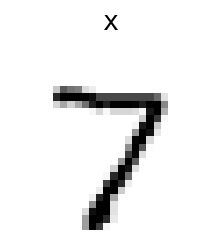

In [6]:
print("Predicted class is {}".format(np.argmax(infer_data["y_pred"])))
img = fe.util.ImgData(x=infer_data["x"])
fig = img.paint_figure()

<a id='t09apphub'></a>

## Apphub Examples
You can find some practical examples of the concepts described here in the following FastEstimator Apphubs:

* [MNIST](../../apphub/image_classification/mnist/mnist.ipynb)
* [IMDB](../../apphub/NLP/imdb/imdb.ipynb)